In [2]:
import numpy as np
import random as random
import matplotlib.pyplot as plt

In [24]:
max = 4.5
step = 0.1
size = round(max / step)
states = np.arange(0, max, step)
actions = np.arange(0, max, step)
T = 2

N = 10000 # number of steps
phi = 15 # soft-min parameter
om_q = 0.85 # rho_q parameter
om_mu = 0.55 # rho_mu parameter
gamma = 0.2 # for production function
rho = 0.95 # discounting (in production function as well)
C = 3 # for production function

jump = round(N / 100) # take a measurement of mu every "jump" step

num_X = len(states)
num_A = len(actions)

Q = np.full((T, num_X, num_A), 30.0) # unified Q function
mu = np.ones([num_X, num_A, T], dtype = float) # separate mean field for each trajectory
mu = mu / 2

supp_W = [0.9, 1.3] # given white noise process with
pmf_W = [0.75, 0.25] # specific supports and probabilities

# calculate expectation of white noise process 
exp_W_gamma = 0
for i in range(len(supp_W)):
    exp_W_gamma += np.pow(supp_W[i], gamma) * pmf_W[i]

# calculate rho * expectation [W ^ gamma]
pEWgamma = rho * exp_W_gamma

# white noise with two outcomes with probabilities established above
def W ():
    return np.random.choice(supp_W, p = pmf_W)

def rhosCalc (count_xat_mu, count_txa_q):
    rhoQ = 1 / np.pow(1 + count_txa_q, om_q)
    rhoMu = 1 / np.pow(1 + count_xat_mu, om_mu)
    return { 'q': rhoQ, 'mu': rhoMu }

# given state/action (by index) and mean field investment
# return through G(mu, W()) * a (amount invested)
# the new state (rounded)
# and using formula for utility calculate reward
def env (state, action, mu):
    consump = states[state] - actions[action]
    production = W() * C / (pEWgamma * (1 + (C - 1) * np.pow(mu, 3)))
    wealth = actions[action] * production
    newState = round(wealth / step)
    utility = np.pow(consump, gamma) / gamma
    # print("%6.4f * %6.4f = %6.4f implies state = %3d" % (actions[action], production, wealth, newState))
    return { 'x': newState, 'u': utility }

# action policy : choose action a given state is x, otherwise use softmin policy
def pi_xa_policy (Q_xa_state, x_idx, a_idx, state):
    if state == x_idx:
        return a_idx
    else:
        return softMinAct(Q_xa_state, state)

# using the formula, calcula te softmax probabilities
# and choose an action given the pmf probabilities
def softMinAct (Q_x, x_idx):
    q = Q_x[:x_idx + 1]
    max_q = np.max(q)

    weights = np.exp(-phi * (max_q - q))
    weights /= weights.sum()
    return np.random.choice(x_idx + 1, p = weights)


In [ ]:
trajectories = np.arr([num_X * (num_A + 1) / 2])
checkpoint_distance = 1000


def checkPathsViability (n, trajs, count_q, q_table):
    totalEpisodes = 1000 * np.sum(trajs)
    # min 1 visit per 100000
    # q-value of under 90% of max (given state)
    # true for all t values

    return { 'traj': trajects,  }

_IncompleteInputError: incomplete input (3619721486.py, line 1)

In [25]:
abridgedmu = []
for x in range(num_X):
    abridgedmu.append([])
    
    for a in range(x + 1):
        abridgedmu[x].append([])

        for t in range(T):
            abridgedmu[x][a].append([])


# for rho calc, the amount of times in the (x, a) trajectory it has visited a specific state action pair
countMu = np.zeros([num_X, num_A, T], dtype = int)

# for rho calc, the amount of times, regardless of trajectory, it has visited a specific state action pair
countQ = np.zeros([T, num_X, num_A], dtype = int)

broke = False

for n in range(N):
    
    print(n)

    state = []
    for x in range(num_X):
        state.append([])
        
        for a in range(x + 1):
            state[x].append(np.random.choice(list(range(0, round(1 / step) + 1))))

    for t in range(T):
    
        for x in range(num_X):

            for a in range(x + 1):

                # use softmin to choose next action
                # print("%3d %3d %3d %3d   " % (state[x][a], x, a, t), end = '')
                action = pi_xa_policy(Q[t][state[x][a]], x, a, state[x][a])

                # update counter for rho calculation
                countMu[x][a][t] += 1
                if state[x][a] == x:
                    countQ[t][x][a] += 1
                rhos = rhosCalc(countMu[x][a][t], countQ[t][x][a]) # use [x][a] because will only update Q if state = x -> action = a

                # input state, action, mu into environment
                # and receive new state and cost
                envir = env(state[x][a], action, mu[x][a][t])
                if envir['x'] >= num_X or envir['x'] < 0:
                    if t < T - 1:
                        print("error: %3d %3d %3d %3d %3d %3d %3d" % (envir['x'], action, state[x][a], x, a, t, n))
                        broke = True
                        break
                            
                # update specific mean field
                mu[x][a][t] += rhos['mu'] * (actions[action] - mu[x][a][t])

                # given state matches the trajectory state, update unified Q matrix, current state, mu distribution
                if state[x][a] == x:
                    # Q[t][x][a] += rhos['q'] * (envir['u'] + gamma * np.max(Q[t][envir['x']]) - Q[t][x][a])
                    if t < T - 1:
                        if envir['x'] > 0:
                            max_next_Q = np.max(Q[t + 1, envir['x'], :envir['x'] + 1])
                        else:
                            max_next_Q = Q[t + 1, 0, 0]
                        td_target = envir['u'] + max_next_Q
                    else:
                        #end state
                        td_target = envir['u'] + rho * np.pow(envir['x'] * step, gamma) / gamma

                    # Q-learning update
                    Q[t, state[x][a], action] = Q[t, state[x][a], action] + rhos['q'] * (td_target - Q[t, state[x][a], action])
    
                state[x][a] = envir['x']

                if n % jump == 0:
                    abridgedmu[x][a][t].append(mu[x][a][t])

            if broke:
                break
        
        if broke:
            break

    if broke:
        break

if broke == False:
    for x in range(num_X):
        for a in range(x + 1):
            for t in range(T):
                abridgedmu[x][a][t].append(mu[x][a][t])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [20]:
for t in range (T):
    print("             t = %1d" % (t))
    for x in range (num_X):
        print("x = %5.2f: " % (states[x]), end = '')
        for a in range (x + 1):
            if countQ[t][x][a] == 0:
                print("        ", end = '')
            else:
                print("%7d " % (countQ[t][x][a]), end = '')
        print("")
    print("")

             t = 0
x =  0.00:     896 
x =  0.10:     967     898 
x =  0.20:     932     860     860 
x =  0.30:     903     919     923     936 
x =  0.40:     902     867     905     903     930 
x =  0.50:     889     902     892     912     897     928 
x =  0.60:     922     911     855     951     948     893     927 
x =  0.70:     875     884     866     902     856     979     874     936 
x =  0.80:     912     882     883     886     945     871     902     939     913 
x =  0.90:     966     890     977     944     872     955     922     922     889     939 
x =  1.00:     928     927     918     903     948     922     951     913     996     886     906 
x =  1.10:                                                                                                 
x =  1.20:                                                                                                         
x =  1.30:                                                                                       

In [ ]:
%matplotlib inline
'''
fig, axs = plt.subplots(len(states), len(actions), figsize=(12, 10))

for x in range(num_X):
    for a in range(x + 1):
        axs[x, a].plot(range(0, N + jump, jump), abridgedmu[x][a], color='blue', linewidth = 1)
        axs[x, a].set_title("Mean Field for Trajectory (x = %1d, a = %1d)" % (x, a))'''

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x106ca9400>>
Traceback (most recent call last):
  File "/Users/derrickchan/Library/Python/3.13/lib/python/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [22]:
print("            a = 0  a = 1")
for x in range(num_X):
    print("x = %5.2f:  " % (states[x]), end = '')
    for a in range(x + 1):
        if countQ[1][x][a] > 30:
            print("%5.2f  " % (Q[1][x][a]), end = '')
        else:
            print("       ", end = '')
    print()

            a = 0  a = 1
x =  0.00:   0.00  
x =  0.10:                
x =  0.20:   3.70   6.68   4.06  
x =  0.30:   3.93   7.13   7.19   4.40  
x =  0.40:   4.16   7.45   7.66   7.55   4.66  
x =  0.50:   4.35   7.68   8.00   8.05   7.82   4.86  
x =  0.60:                                                   
x =  0.70:   4.76   8.11   8.40   8.56   8.59   8.53   8.17   5.18  
x =  0.80:   4.78   8.18   8.64   8.83   8.89   8.82   8.69   8.34   5.30  
x =  0.90:                                                                        
x =  1.00:          8.48   8.96   9.12   9.24   9.26   9.24   9.16   8.96   8.61   5.54  
x =  1.10:   5.10   8.51   8.96   9.22   9.36   9.42   9.45   9.41   9.32   9.12   8.76   5.71  
x =  1.20:   5.24   8.63   9.14   9.34   9.45   9.55   9.57   9.68   9.48   9.33   9.21   8.84   5.78  
x =  1.30:   5.27   8.71   9.25   9.48   9.62   9.70   9.75   9.75   9.72   9.63   9.51   9.28   8.89   5.82  
x =  1.40:   5.39   8.88   9.32   9.52   9.67   9.80   9.8

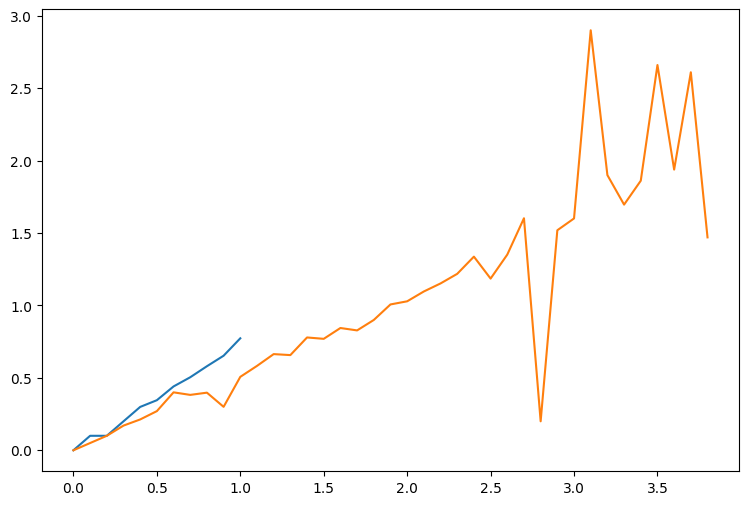

In [23]:
# utilizing the soft max distribution
# calculate the expectation of an action choice
def softMaxMean (Q_tx, x_idx):
    sum = 0
    expectation = 0
    weights = np.zeros(x_idx + 1)
    for a in range(x_idx + 1):
        weights[a] = np.exp(phi * Q_tx[a])
        sum += weights[a]
        expectation += weights[a] * actions[a]
    return expectation / sum

# iterate through each time step and state to calculate optimal policy from soft max expectation
# only calculate for policy for time/state pairs that were visited at least "qualify" times
qualify = 30
optimIND = []
optim = []
for t in range (T):
    optim.append([])
    optimIND.append([])
    for x in range (size):
        if (np.sum(countQ[t, x]) > qualify):
            optim[t].append(softMaxMean(Q[t, x, :], x))
            optimIND[t].append(states[x])

%matplotlib inline

plt.figure(figsize = (9, 6))
plt.plot(optimIND[0], optim[0])
plt.plot(optimIND[1], optim[1])